In [119]:
# Import necessary libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

import tensorflow as tf

In [120]:
# Hyperparameters data loading

base_file_path = 'C:/Users/nikoLocal/Documents/Opencampus/Machine_Vision_challenge_data/'
image_path = base_file_path + '/input_train/input_train'

label_csv_name = 'Y_train_eVW9jym.csv'


In [121]:
# Load the data and briefly inspect

# load data from csv to pandas dataframe
train_df = pd.read_csv(os.path.join(base_file_path, label_csv_name))

train_df.head()

train_df.duplicated(subset='filename').value_counts()
#result: no duplicated file names


False    8278
Name: count, dtype: int64

In [122]:
# Import random Test Dataset

submission_csv_name = 'Y_random_nKwalR1.csv'
submission_image_path = base_file_path + '/input_test_1a4aqAg/input_test'

submission_test_df = pd.read_csv(os.path.join(base_file_path, submission_csv_name))


In [123]:
#ToDo - assign each label a number according to the website so that there is no confusion as to what is what!

#add another column to the dataframe according

dict_numbers = {'GOOD': 0,'Boucle plate':1,'Lift-off blanc':2,'Lift-off noir':3,'Missing':4,'Short circuit MOS':5}
dict_strings = {'GOOD': '0_GOOD','Boucle plate':'1_Flat loop','Lift-off blanc':'2_White lift-off','Lift-off noir':'3_Black lift-off','Missing':'4_Missing','Short circuit MOS':'5_Short circuit MOS'}

label_list = ['0_GOOD','1_Flat loop','2_White lift-off','3_Black lift-off','4_Missing','5_Short circuit MOS']
#label_list.sort()

train_df['LabelNum'] = train_df['Label'].map(dict_numbers)
train_df['LabelStr'] = train_df['Label'].map(dict_strings)

In [124]:
#Process label submission test dataframe

dict_strings_sub = {0: '0_GOOD',1:'1_Flat loop',2:'2_White lift-off',3:'3_Black lift-off',4:'4_Missing',5:'5_Short circuit MOS',6:'6_Drift'}

submission_test_df['LabelStr'] = submission_test_df['Label'].map(dict_strings_sub)

submission_test_df.head()

,Unnamed: 0,filename,window,lib,Label,LabelStr
0,0,15669dca9fa601ffded9be0f9cd48097d45e7e05d662b8...,2003,Die01,5,5_Short circuit MOS
1,1,16a9a7106da45758c103a182306d6e2991634e0574edce...,2003,Die01,1,1_Flat loop
2,2,216d84546bb291a840ac2ad0752a828f1f3d64abf79191...,2003,Die01,5,5_Short circuit MOS
3,3,219a89d631e95e19643566512d8bcc45233fe4fe0524c9...,2003,Die01,6,6_Drift
4,4,2a441bba89ae0a867b3ee938063d55538379f8e1298b3c...,2003,Die01,1,1_Flat loop


In [125]:
train_df.head()

,Unnamed: 0,filename,window,lib,Label,LabelNum,LabelStr
0,0,15b3bab7c186fd35b65df777890c427dd243feacbb85dd...,2003,Die01,Missing,4,4_Missing
1,1,1856617e1ac2d821a46a41b938818f0169342226a78f93...,2003,Die01,GOOD,0,0_GOOD
2,2,19066cce773b3a092ebf4311b11858aa653da6f8274957...,2003,Die01,Missing,4,4_Missing
3,3,19c10caf4b24284e1748caed62d94cbb689d6b379b1cf5...,2003,Die01,GOOD,0,0_GOOD
4,4,1a627426d55a668df8bcd381a7fa87b620481995b6755f...,2003,Die01,Missing,4,4_Missing


In [126]:
# Take dataframe subsets for specific tasks, i.e. balanced datasets

#Hyperparameters:
test_split = 0.2
val_split = 0.2 # remember - this is fractional  after the test data has been split from the initial balanced sub dataset

# list of Labels = Missing  , GOOD  , Lift-off blanc  , Short circuit MOS   ,  Lift-off noir   , Boucle plate
#included_labels = ['GOOD', 'Missing','Lift-off blanc','Short circuit MOS','Lift-off noir','Boucle plate']
included_labels = ['0_GOOD','1_Flat loop','2_White lift-off','3_Black lift-off','4_Missing','5_Short circuit MOS']
num_classes = len(included_labels)

# get counts of label with the least entries
countList = train_df['LabelStr'].value_counts()
minCounts = countList[included_labels].min()

BalancedDF = pd.DataFrame()

#concat sampled dataframes for each included label
for i in range(num_classes):
    BalancedDF = pd.concat([BalancedDF,train_df[train_df['LabelStr'] == included_labels[i]].sample(n=minCounts)],axis=0)

#test if worked as intended
BalancedDF['LabelStr'].value_counts()

#make train-test split using sklean function
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

#split dataframe according to fractional test size
train_df_balanced, test_df_balanced = train_test_split(BalancedDF, test_size=test_split, random_state=42) #keep random state constant to ensure comparability



In [127]:
train_df_balanced['Label'].value_counts()

Label
Missing              62
Lift-off noir        58
Lift-off blanc       57
Short circuit MOS    56
GOOD                 54
Boucle plate         53
Name: count, dtype: int64

In [128]:
# initialize ImageDataGenerators
# use ImageDataGen because it has method flow_from_dataframe() that works really well together with pandas dataframes
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# although deprecated the functionality can be used as discussed in feedback session

from keras.src.legacy.preprocessing.image import ImageDataGenerator

# HYPERPARAMTERS ########

target_size = (256,256) #pixel size to load img
class_mode = 'categorical' # how to store labels - either categorical (one-hot encoding) or as numbers
#class_mode = 'input'
batch_size = 8 #later player around with batch size to see how it affects performance
labelCol = 'LabelStr'
#########################

#normalize pixel intensities
rescale = 1.0/255.0

datagen = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=0.0,
    shear_range=0.0,
    rescale=rescale,
    validation_split=val_split)

datagen_augmentation = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=35,
    shear_range= 12,
    zoom_range = 0.10,
    rescale=rescale,
    validation_split=val_split)

datagen_test = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=0.0,
    shear_range=0.0,
    rescale=rescale,
    validation_split=0.0)

datagen_submission_test = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=0.0,
    shear_range=0.0,
    rescale=rescale,
    validation_split=0.0)

##########################################################

train_generator = datagen.flow_from_dataframe(
    train_df_balanced,
    image_path,
    x_col='filename',
    y_col=labelCol,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    subset='training')

train_generator_val = datagen.flow_from_dataframe(
    train_df_balanced,
    image_path,
    x_col='filename',
    y_col=labelCol,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    subset='validation')

train_generator_aug = datagen_augmentation.flow_from_dataframe(
    train_df_balanced,
    image_path,
    x_col='filename',
    y_col=labelCol,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    subset='training')

train_generator_aug_val = datagen_augmentation.flow_from_dataframe(
    train_df_balanced,
    image_path,
    x_col='filename',
    y_col=labelCol,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    subset='validation')

# To Do - make another Test gen. It does not really need to be balanced
# keep now for testing purposes - lower runtime

test_generator = datagen_test.flow_from_dataframe(
    test_df_balanced,
    image_path,
    x_col='filename',
    y_col=labelCol,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=True,
    seed=42,
    subset='training')

test_generator_metrics = datagen_submission_test.flow_from_dataframe(
    test_df_balanced,
    image_path,
    x_col='filename',
    y_col=labelCol,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1,
    color_mode="grayscale",
    shuffle=False,
    seed=42,
    subset='training')

#generator for submission test data

test_generator_submission = datagen_test.flow_from_dataframe(
    submission_test_df,
    submission_image_path,
    x_col='filename',
    y_col='LabelStr',
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1,
    color_mode="grayscale",
    shuffle=False,
    seed=42,
    subset='training')


Found 272 validated image filenames belonging to 6 classes.
Found 68 validated image filenames belonging to 6 classes.
Found 272 validated image filenames belonging to 6 classes.
Found 68 validated image filenames belonging to 6 classes.
Found 86 validated image filenames belonging to 6 classes.
Found 86 validated image filenames belonging to 6 classes.
Found 1055 validated image filenames belonging to 7 classes.


In [129]:
# build a model to be used as baseline model
# use "simplest" CNN as baseline

model_simple_CNN = tf.keras.Sequential([
    tf.keras.layers.Input((target_size[0], target_size[1], 1)),  #image are greyscale - so in total dim (width,height,1)
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax"),
])

model_simple_CNN.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,509,766 (120.20 MB)

 Trainable params: 31,509,766 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
# compile Model

model_simple_CNN.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    #loss=tf.keras.losses.SparseCategoricalCrossentropy,
    #metrics=["accuracy",'precision',]
    metrics=["accuracy",'precision','recall',tf.keras.metrics.F1Score(average='weighted')]
)

#F1 average parameter needs to be anything other than None if using linewise output when fiting the model...

In [131]:
# To Do - set stopping criteria via callbacks. Either based on accuracy or decreasing changes in validation loss

# callback that monitors validation accuracy / loss
# https://keras.io/api/callbacks/early_stopping/
val_loss_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True,
    verbose = 2
)


In [132]:
history = model_simple_CNN.fit(
    train_generator_aug,
    validation_data = train_generator_val,
    epochs=50,
    callbacks=[val_loss_stop],
    verbose = 2 #2 is one line per epoch -
)

Epoch 1/50
34/34 - 13s - 372ms/step - accuracy: 0.1949 - f1_score: 0.1629 - loss: 3.3032 - precision: 0.2353 - recall: 0.0294 - val_accuracy: 0.1765 - val_f1_score: 0.1273 - val_loss: 1.7926 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
34/34 - 10s - 304ms/step - accuracy: 0.3566 - f1_score: 0.2979 - loss: 1.5660 - precision: 0.7727 - recall: 0.0625 - val_accuracy: 0.5294 - val_f1_score: 0.4801 - val_loss: 1.1998 - val_precision: 0.6429 - val_recall: 0.2647
Epoch 3/50
34/34 - 11s - 324ms/step - accuracy: 0.5588 - f1_score: 0.5519 - loss: 1.1895 - precision: 0.7521 - recall: 0.3235 - val_accuracy: 0.6471 - val_f1_score: 0.6238 - val_loss: 1.0962 - val_precision: 0.7037 - val_recall: 0.2794
Epoch 4/50
34/34 - 11s - 322ms/step - accuracy: 0.5699 - f1_score: 0.5712 - loss: 1.0931 - precision: 0.6954 - recall: 0.3860 - val_accuracy: 0.7500 - val_f1_score: 0.7527 - val_loss: 0.9019 - val_precision: 0.8750 - val_recall: 0.4118
Epoch 5/50
34/34 - 12s - 345ms/step - accuracy: 

In [133]:
# test accuracy on test data
test_loss, test_accuracy, test_precision, test_recall,test_f1_score = model_simple_CNN.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.3g} | Test Loss: {test_loss:.3g} | Test Precision: {test_precision:.3g} | Test Recall: {test_recall:.3g} | Test F1 Score: {test_f1_score:.3g}:")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9070 - f1_score: 0.9079 - loss: 0.3221 - precision: 0.9070 - recall: 0.9070
Test Accuracy: 0.907 | Test Loss: 0.322 | Test Precision: 0.907 | Test Recall: 0.907 | Test F1 Score: 0.908:


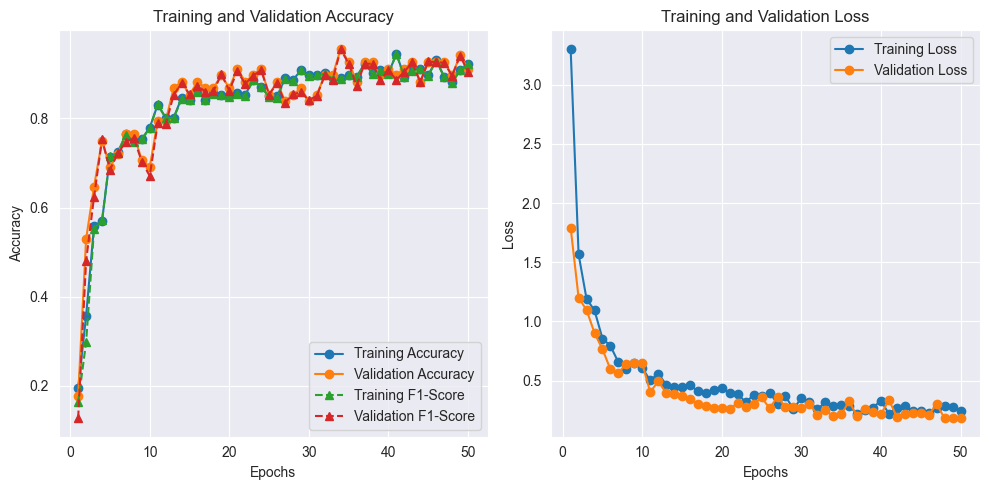

In [134]:
# plot metrics over the course of model training

from matplotlib.ticker import StrMethodFormatter

training_accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]

training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]

training_f1 = history.history["f1_score"]
validation_f1 = history.history["val_f1_score"]

# Setting up the number of epochs for the x-axis
epochs_range = range(1, len(training_accuracy) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy,'o-', label="Training Accuracy")
plt.plot(epochs_range, validation_accuracy,'o-', label="Validation Accuracy")
plt.plot(epochs_range, training_f1,'^--', label="Training F1-Score")
plt.plot(epochs_range, validation_f1,'^--', label="Validation F1-Score")
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss,'o-', label="Training Loss")
plt.plot(epochs_range, validation_loss,'o-', label="Validation Loss")
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [135]:
#get predicted and true labels for the test dataset

#get true labels from generator:
#  https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict-generator

from keras.utils import to_categorical

# test_generator.labels and test_generator.classes seem to be identical
#test_generator_metrics.classes

true_labels = test_generator_metrics.classes
#make into one hot encoding
#true_labels = to_categorical(true_labels, num_classes=6)

# model.predict directly gives you the output of the last mode layer. so percentages when using i.e. 'softmax'
predicted_labels = model_simple_CNN.predict(test_generator_metrics)

#convert to numerical - np.argmax directly does the job
predicted_labels = np.argmax(predicted_labels, axis=-1)

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [136]:
#true_labels[:10]

In [137]:
#test_df_balanced.head(10)

In [138]:
# IMPORTANT
# ImageDataGen and FlowFromDataFrame make numerical (categorical) labels from the Str labels by sorting them numerically.
# Thus, by sorting  the labels by hand via numbers in front we can guarantee the correct numerical label outputs matching the challenge online

In [150]:
#use more sophisticated metrics
from sklearn.metrics import classification_report

#classification report does NOT work with one hot encoding
print(classification_report(true_labels, predicted_labels,target_names = label_list))

#save as dict for future use as well

report = classification_report(true_labels, predicted_labels,target_names = label_list,output_dict=True)
#convert to dataframe for easy use and saving to csv
report_df = pd.DataFrame(report).transpose()

#save to file
metrics_baseline_savename = base_file_path + '/' + 'metrics_baseline.csv'

report_df.to_csv(metrics_baseline_savename)

                     precision    recall  f1-score   support

             0_GOOD       1.00      0.94      0.97        17
        1_Flat loop       0.83      0.83      0.83        18
   2_White lift-off       0.80      0.86      0.83        14
   3_Black lift-off       0.92      0.92      0.92        13
          4_Missing       0.90      1.00      0.95         9
5_Short circuit MOS       1.00      0.93      0.97        15

           accuracy                           0.91        86
          macro avg       0.91      0.91      0.91        86
       weighted avg       0.91      0.91      0.91        86



Small explanation of the metrics:

Precision:

Recall:

_____________________

Our task:

We are classifying correctly working vs defective parts. In the context of machine vision inspection it is more desirable to false detect a defect (falso positive) then to miss a defect. Thus, recall seems like the best metric to use.
However, the classification is not binary but consisting of 6 (7) classes. There are multiple defective classes and one good (as well as one undefined/ misc class). Consequently, either each class should use its own metric. Alternatively, the F1-score could be used for all classes giving a mean evaluation of precision and recall. In this stage of the project we will use the F1 score to evaluate models and hyperparameters.
In order to fully evaluate all models we will also save a classification report to file using sklearn.metrics.classification_report for calculation.

(https://en.wikipedia.org/wiki/Precision_and_recall)


In [140]:
'''
from sklearn.utils import class_weight as cw

def get_weight(y):
    class_weight_current =  cw.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

a = get_weight(train_generator.classes)
'''

"\nfrom sklearn.utils import class_weight as cw\n\ndef get_weight(y):\n    class_weight_current =  cw.compute_class_weight('balanced', np.unique(y), y)\n    return class_weight_current\n\na = get_weight(train_generator.classes)\n"

Setup most simple baseline model for Test data including the "Drift" class (Class No. 6)
Test against the random submission / publicly available Test data. Careful: the labels cannot be assumed to be the true labels - therefore take the results as an indication only.
(From challenge leaderboard it can be assumed, that the labels are at least ~85% accurate)


In [141]:
# define function that uses previously trained model to process the data and assign labels 0 - 6
# for comparison with public test data (see note above)



In [143]:
# for playing around and testing
pred_label_list = list()

#total treshold
# test which value makes sense. maybe one  treshold per class would be better
certainty_threshold = 0.8

# loop doesn't stop - why?
# test_generator_metrics is not shuffled
i_run = 0
for data in test_generator_submission:
    prediction = model_simple_CNN.predict(data,verbose=0)

    predicted_label = np.argmax(prediction, axis=-1)[0]
    label_certainty = prediction[0][predicted_label]

    #check whether label is predicted with high certainty
    if label_certainty > certainty_threshold:
        pred_label_list.append(predicted_label)
    else:
        pred_label_list.append(6) #append drift label if model is too uncertain


    i_run = i_run + 1
    if i_run == len(test_generator_submission):
        print("{} items processed".format(i_run))
        break



1055 items processed


In [144]:
# add column to dataframe

submission_test_df_compare = submission_test_df.copy(deep=True)
submission_test_df_compare['predicted Labels'] = pred_label_list

#save to file
submission_csv_comparison_save = base_file_path + '/' + submission_csv_name + '_predicted.csv'

submission_test_df_compare.to_csv(submission_csv_comparison_save)

In [145]:
submission_test_df_compare.head(10)

,Unnamed: 0,filename,window,lib,Label,LabelStr,predicted Labels
0,0,15669dca9fa601ffded9be0f9cd48097d45e7e05d662b8...,2003,Die01,5,5_Short circuit MOS,4
1,1,16a9a7106da45758c103a182306d6e2991634e0574edce...,2003,Die01,1,1_Flat loop,0
2,2,216d84546bb291a840ac2ad0752a828f1f3d64abf79191...,2003,Die01,5,5_Short circuit MOS,0
3,3,219a89d631e95e19643566512d8bcc45233fe4fe0524c9...,2003,Die01,6,6_Drift,6
4,4,2a441bba89ae0a867b3ee938063d55538379f8e1298b3c...,2003,Die01,1,1_Flat loop,4
5,5,30a80f601351668150ab9d82e529bc80f4a0b8c182c5c3...,2003,Die01,3,3_Black lift-off,4
6,6,31887e6318dfc56b329e3e0cfb20e9708afe6005473833...,2003,Die01,6,6_Drift,4
7,7,3dc022d18cdd8a54b83e4fb1eba8014e5b01fe847e9c65...,2003,Die01,1,1_Flat loop,4
8,8,4774ea626d257b9701b14d41b892e3b8100c6628beef30...,2003,Die01,6,6_Drift,4
9,9,48ab0456090554a52a395ee560e261df40b33ee3143a54...,2003,Die01,6,6_Drift,4


Quick manual inspection of a few image and labels of the comparison shows, that the submissions labels are wrong most of the time.
In conclusion this data CANNOT be used to train or evaluate any models.

The data could be used, however, to train detection of "Drift" data by manually creating labeled data to find possible drift images.
-> Do this in a python program that automatically loads images and gives you the option for Drift / no drift.

In [147]:
true_labels_test = submission_test_df_compare['Label']
predicted_labels_test = submission_test_df_compare['predicted Labels']

label_list_test =  ['0_GOOD','1_Flat loop','2_White lift-off','3_Black lift-off','4_Missing','5_Short circuit MOS','6_Drift']

print(classification_report(true_labels_test, predicted_labels_test,target_names = label_list_test))

                     precision    recall  f1-score   support

             0_GOOD       0.06      0.06      0.06       144
        1_Flat loop       0.08      0.01      0.01       156
   2_White lift-off       0.32      0.04      0.07       154
   3_Black lift-off       0.09      0.01      0.02       156
          4_Missing       0.14      0.70      0.23       143
5_Short circuit MOS       0.07      0.01      0.02       159
            6_Drift       0.17      0.15      0.16       143

           accuracy                           0.13      1055
          macro avg       0.13      0.14      0.08      1055
       weighted avg       0.13      0.13      0.08      1055

